In [1]:
import torch
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy
import numpy as np
from PIL import Image

data_train = datasets.MNIST(root="./dataset",train=True,download=True,transform=transforms.ToTensor())
data_test = datasets.MNIST(root="./dataset",train=False,download=True,transform=transforms.ToTensor())

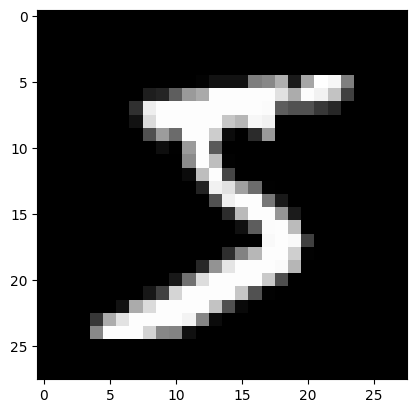

In [2]:
from matplotlib import pyplot as plt

image, label = data_train[0]

plt.imshow(image.squeeze().numpy(),cmap='gray')
plt.show()

In [3]:
train_dataset = []

for x , y in data_train:

    list_temp = [0,0,0,0,0,0,0,0,0,0]

    list_temp[y] = 1
    
    y = np.array(list_temp)

    x = x.squeeze().reshape(-1).numpy()

    train_dataset.append([x,y])

test_dataset = []

for x , y in data_test:

    list_temp = [0,0,0,0,0,0,0,0,0,0]

    list_temp[y] = 1
    
    y = np.array(list_temp)

    x = x.squeeze().reshape(-1).numpy()

    test_dataset.append([x,y])

In [4]:
from torch.utils.data import dataset, DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=600,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=100,shuffle=True)

In [5]:
import torch.nn as nn

class HiddenSoftMaxNet(nn.Module):
    
    def __init__(self,hidden_layer:list=[]):
        super(HiddenSoftMaxNet, self).__init__()
        
        self.fc = []
        self.af = []
        
        if len(hidden_layer) == 0:
            self.fc.append(nn.Linear(784,10))
        else :
            input_current = 784
            
            for num_class in hidden_layer :
                self.fc.append(nn.Linear(input_current,num_class))
                self.af.append(nn.ReLU())
                input_current = num_class
                
            self.fc.append(nn.Linear(input_current,10))
            self.af.append(nn.Softmax(1))
            
        self.fc = nn.ParameterList(self.fc)
        self.af = nn.ParameterList(self.af)
        
    def forward(self,input):
        
        rfc = input
        
        for func,afunc in zip(self.fc,self.af):
            rfc = func(rfc)
            rfc = afunc(rfc) 
            
        output = rfc
        
        return output
    
net = HiddenSoftMaxNet([128,64,32])

In [6]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.01)

loss_fc = nn.CrossEntropyLoss()

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [8]:
def resize_tensor(tensor):
    
    v_min, v_max = tensor.min(), tensor.max()
    
    new_min,new_max = 0,255
    
    v_p = (tensor - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
    
    return v_p
    

In [9]:
from torcheval.metrics import MulticlassAccuracy

In [10]:
epochs = 2000

for epoch in range(1,epochs+1):

    loss_sum = 0.0

    metric = MulticlassAccuracy()

    for (train_features,train_labels),(test_features,test_labels) in zip(train_dataloader,test_dataloader) :

        epoch_y = net(train_features)
        loss = loss_fc(epoch_y.to(torch.float32),train_labels.to(torch.float32))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 학습중인 내용을 IMG로 보려 하였던 노력의 잔해.
        """if (epoch) % 100 == 0 :
            net_idx = 0
            for m,layer in zip(net.modules(),net.hidden_layer) :
                if isinstance(m,nn.Linear):
                    
                    img_tensor = m.weight.clone().detach()
                    img = resize_tensor(img_tensor.squeeze())
                
                    img = img.reshape(layer,-1,-1)
                    np_arr = np.array(img,dtype=np.uint8)
                                        
                    for img_num ,i in zip(np_arr,range(len(np_arr))):
                        writer.add_image(f'weight_{net_idx}_img_{i}',img_num,epoch,dataformats='WH')
                    net_idx += 1"""

        loss_sum += loss
        
        epoch_test_y = net(test_features)
        epoch_class_y = torch.argmax(epoch_test_y,dim=-1)
        test_class_y = torch.argmax(test_labels,dim=-1)

        metric.update(epoch_class_y,test_class_y)
        
    acc = metric.compute()

    loss = loss_sum / len(train_dataloader)

    print('Epoch {:4d}/{} train_loss: {:.6f} acc: {:.6f}'.format(
        epoch, epochs, loss, acc
    ))

    if loss < 0.1 :
        """net_idx = 0
        for m,layer in zip(net.modules(),net.hidden_layer) :
            if isinstance(m,nn.Linear):
            
                img_tensor = m.weight.clone().detach()
                img = resize_tensor(img_tensor.squeeze())
                
                img = img.reshape(layer,-1,-1)
                np_arr = np.array(img,dtype=np.uint8)
                                        
                for img_num ,i in zip(np_arr,range(len(np_arr))):
                    writer.add_image(f'weight_{net_idx}_img_{i}',img_num,epoch,dataformats='WH')
                net_idx += 1"""
        break

Epoch    1/2000 train_loss: 2.302369 acc: 0.113500
Epoch    2/2000 train_loss: 2.302296 acc: 0.113500
Epoch    3/2000 train_loss: 2.302223 acc: 0.113500
Epoch    4/2000 train_loss: 2.302149 acc: 0.113500
Epoch    5/2000 train_loss: 2.302073 acc: 0.113500
Epoch    6/2000 train_loss: 2.301997 acc: 0.113500
Epoch    7/2000 train_loss: 2.301919 acc: 0.113500
Epoch    8/2000 train_loss: 2.301839 acc: 0.113500
Epoch    9/2000 train_loss: 2.301758 acc: 0.113500
Epoch   10/2000 train_loss: 2.301674 acc: 0.113500
Epoch   11/2000 train_loss: 2.301589 acc: 0.113500
Epoch   12/2000 train_loss: 2.301500 acc: 0.113500
Epoch   13/2000 train_loss: 2.301408 acc: 0.113500
Epoch   14/2000 train_loss: 2.301313 acc: 0.113500
Epoch   15/2000 train_loss: 2.301215 acc: 0.113500
Epoch   16/2000 train_loss: 2.301110 acc: 0.113500
Epoch   17/2000 train_loss: 2.301003 acc: 0.113500
Epoch   18/2000 train_loss: 2.300889 acc: 0.113500
Epoch   19/2000 train_loss: 2.300770 acc: 0.113500
Epoch   20/2000 train_loss: 2.3

In [11]:
x = torch.tensor([test_dataset[40][0]])

pre_y = net(x)

pre_y = pre_y.squeeze()

pre_max = 0
temp = -1

for pre_data,i in zip(pre_y,range(len(pre_y))):
    
    if pre_data > pre_max:
        temp = i
        pre_max = pre_data
temp



/tmp/ipykernel_27542/3555199059.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x = torch.tensor([test_dataset[40][0]])


1

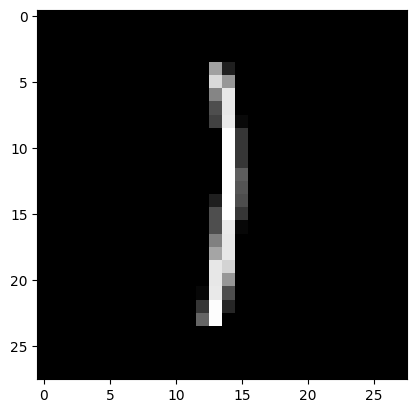

In [12]:
from matplotlib import pyplot as plt

plt.imshow(x.squeeze().reshape(28,28).numpy(),cmap='gray')
plt.show()